### Figure 3
 - Explained variance each subject individually
 

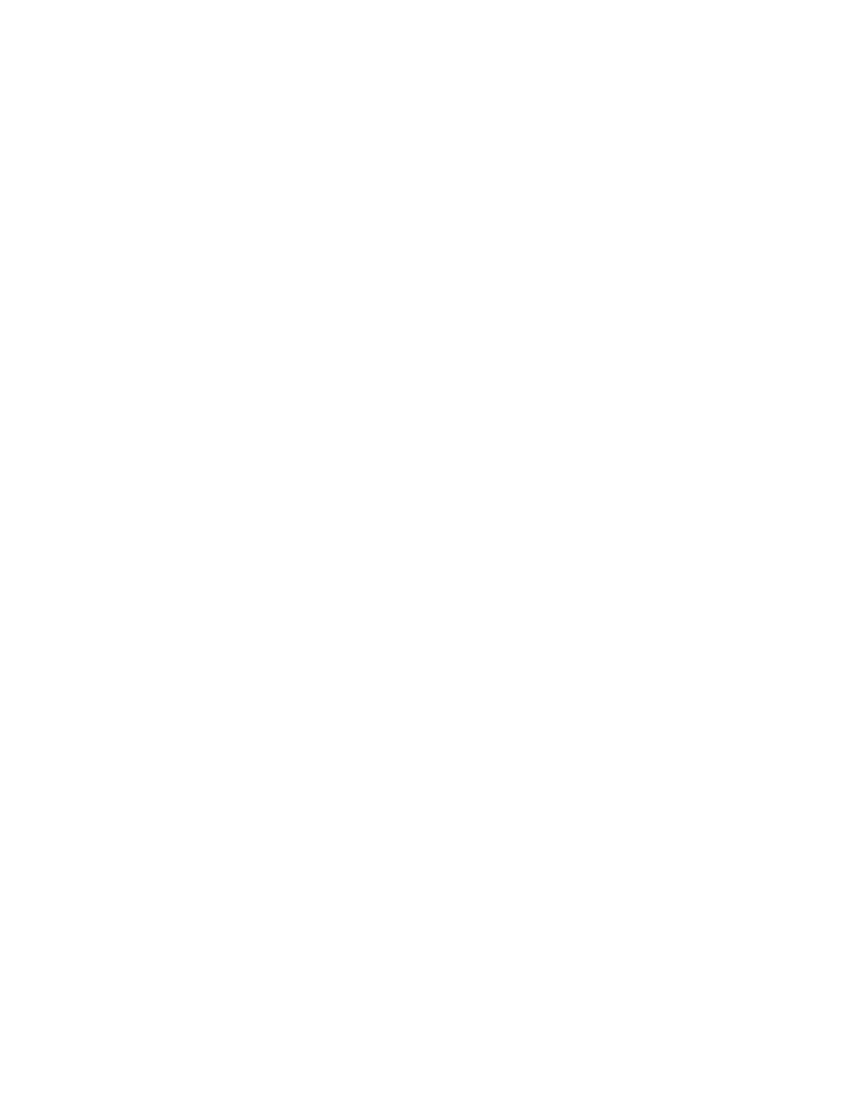

In [1]:
%matplotlib widget
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import subjects
from neuropy import plotting

grpdata = subjects.GroupData()
group = ['nsd','sd']
ev_df = grpdata.ev_pooled.reset_index(drop=True)
ev_df['ev_diff'] = ev_df['ev']-ev_df['rev']

fig = plotting.Fig(grid=(8,4),hspace=0.3,wspace=0.35)
filename = subjects.figpath_sd / 'figure3'
caption = "Figure 3: MAZE reactivation during POST. \n(A) Explained variance (EV) in POST for each session of SD (orange) and NSD (purple) group with chance levels (gray). Error bars indicate +/- stdev. \n(B) Mean explained variance pooled across SD and NSD sessions. Error bars indicate +/- SEM."

### Individual EVs

In [2]:
y_lim = [0.4, 0.2, 0.27, 0.15, 0.27, 0.25]

ev_colors = [subjects.nsd.color(1.2), subjects.sd.color(1.2)]
for i, grp in enumerate(group):
    grp_df = ev_df[ev_df["grp"] == grp]
    subs = np.unique(grp_df["sub"])
    n_subs = len(subs)
    for sub_i, sub in enumerate(subs):
        df = grp_df[grp_df["sub"] == sub]
        sex = df.sex.iloc[0]
        t, ev, ev_err, rev, rev_err = (
            df["Zt"],
            df["ev"],
            df["ev_std"],
            df["rev"],
            df["rev_std"],
        )

        ax = fig.subplot(fig.gs[sub_i, i])
        ax.fill_between(
            t,
            rev - rev_err,
            rev + rev_err,
            color="gray",
            alpha=0.5,
            linewidth=0,
            ec=None,
        )
        ax.plot(t, rev, color="gray")
        ax.fill_between(
            t,
            ev - ev_err,
            ev + ev_err,
            color=ev_colors[i],
            alpha=0.5,
            linewidth=0,
            ec=None,
        )
        if sub == 6:
            fig.legend(ax, ["NSD"], [ev_colors[0]])
            fig.panel_label(ax, "A", x=-0.2, y=1.5)
            ax.set_title("Explained variance in POST")
        if sub == 0:
            fig.legend(ax, ["SD"], [ev_colors[1]])
        if i == 0:
            ax.set_ylabel('EV')
            if sex =='female':
                symbol =[u'$\u2640$']
                symbol_color = ['#F50057']
            else:
                symbol =[u'$\u2642$']
                symbol_color = ['#2962FF']

            fig.legend(ax,symbol,color=symbol_color,x=-0.4,y=1)

        if sub == 5 or sub == 10:
            ax.set_xlabel("Zt time (h)")

        ax.plot(t, ev, color=ev_colors[i])
        # sns.lineplot(data=df,x='Zt',y='ev',ci=None,ax=ax,color=ev_colors[i])
        # sns.lineplot(data=df,x='Zt',y='rev',ci=None,ax=ax,color='gray')
        ax.set_xticks([1, 3, 5, 7, 9])
        ax.set_ylim([0, y_lim[sub_i]])


# sns.lineplot(data=ev_df,x='time',y='ev_diff',hue='grp',ax=ax,ci=None,estimator=np.median)


### Pooled Evs

In [3]:
pooled_ev_hour_df = pd.DataFrame()
for i, grp in enumerate(group):
    grp_df = ev_df[ev_df["grp"] == grp]
    subs = np.unique(grp_df["sub"])
    for sub_i, sub in enumerate(subs):
        sub_df = grp_df[grp_df["sub"] == sub]
        zt, ev = sub_df["Zt"], sub_df["ev"]
        ev_h, t = stats.binned_statistic(zt, ev, bins=np.arange(10))[:2]
        pooled_ev_hour_df = pooled_ev_hour_df.append(
            pd.DataFrame({"Zt": t[1:], "ev": ev_h, "sub": sub, "grp": grp}),
            ignore_index=True,
        )


ev_colors = [subjects.sd.color(1.5), subjects.nsd.color(1.5)]
val = [-0.2, 0.2]

ax = fig.subplot(fig.gs[:2, 2:])
for i, grp in enumerate(["sd", "nsd"]):
    df = pooled_ev_hour_df[pooled_ev_hour_df["grp"] == grp]
    mean_ev = df.groupby("Zt").mean()
    sem_ev = df.groupby("Zt").sem(ddof=0).ev

    ax.bar(
        mean_ev.index + val[i],
        mean_ev.ev,
        color=ev_colors[i],
        yerr=sem_ev,
        # alpha=0.4,
        capsize=1.8,
        width=0.4,
        ec='#7e7c7c',
        ecolor="#545454",
        # linewidth=2,
    )
ax.set_xticks([1,3,5,7,9])
ax.set_xlabel('Zt time (h)')
ax.set_ylabel('EV')
ax.set_title('Pooled explained variance in POST',loc='left')
fig.panel_label(ax,'B')
fig.legend(ax,['SD','NSD'],ev_colors)
    # ax.plot(t, ev_mean, color=ev_colors[i])


/tmp/ipykernel_4085705/2460832793.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pooled_ev_hour_df = pooled_ev_hour_df.append(


### saving

In [4]:
# fig.savefig(filename,caption=caption)